In [3]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings(action="once")
from multiprocessing import  Pool

sns.set_style("darkgrid", {'xtick.top': True, 'ytick.right': True,'xtick.bottom': True, 'ytick.left': True,'grid.linestyle': '--','image.cmap': 'viridis','xtick.direction': 'in', 'ytick.direction': 'in'})

# @working path
FIG_PATH     = '../tex/figs/'
WEB_FIG_PATH = '../tex/web-figs/'
DATA_PATH    = '../code/'


# @global settings

FIG_DPI      = 800
FIG_EXT      = '.pdf'

# @global functions
def savefig(handler,name, fig_ext = FIG_EXT):
    if name != '':
        handler.savefig(FIG_PATH + name + fig_ext, dpi = FIG_DPI,bbox_inches = 'tight', pad_inches = 0.1)
        
def parallelize_dataframe(n_cores, func, df, *args):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.starmap(func, [(d,*args) for d in df_split]))
    pool.close()
    pool.join()
    return df

def parallelize(n_cores, func, splited_data, *args):
    pool = Pool(n_cores)
    df = pool.starmap(func, [(d,*args) for d in splited_data])
    pool.close()
    pool.join()
    return df

Populating the interactive namespace from numpy and matplotlib


In [4]:

PC     = 648000/np.pi
KPC    = 1000*PC 
AU     = 1
MS     = 1
YR     = 2 * np.pi
Hubble_t = 13.4e9*YR
V_UNIT = 2.9784651272402163E1
KMS    = 1.0/V_UNIT
lc     = 299792.458/V_UNIT
DAY    = YR/365.25636042
HR     = DAY/24
G= 1
ly=0.306601*PC

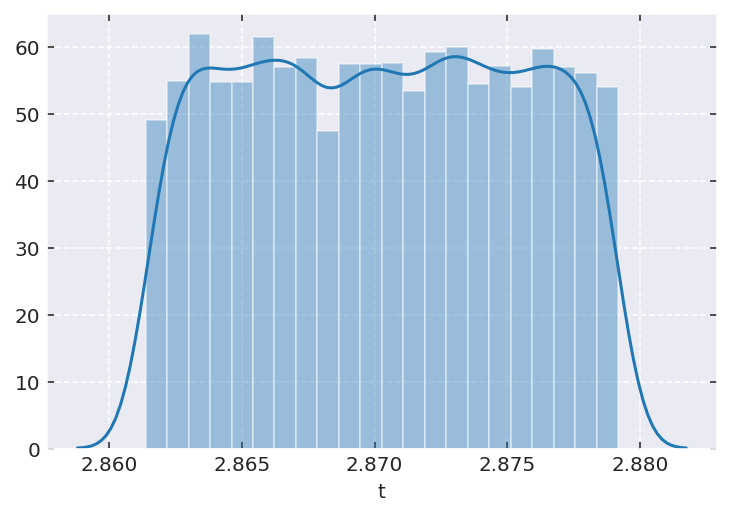

In [41]:
d = np.loadtxt('../code/teest_0.txt')
df = pd.DataFrame(d,columns=['m1', 'm2', 'p','e','i','Omega','omega','nu','t'])
a =  df['p']/(1-df['e']**2)
b = -a*np.sqrt(df['e']**2-1) 
sns.distplot(df['t'])

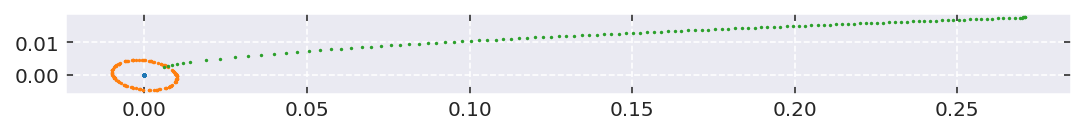

In [115]:
out = np.loadtxt('../code/output.txt')
t=out[:,0]
p1 = out[:,5:8] 
p2 = out[:,15:18]
p3 = out[:,25:28]

p3 = p3  -p1
p2 = p2 -p1
p1 = p1 -p1
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
ax.scatter(p1[:,0], p1[:,1],s=0.5)
ax.scatter(p2[:,0], p2[:,1],s=0.5)
ax.scatter(p3[:,0], p3[:,1],s=0.5)
ax.set_aspect('equal', 'box')

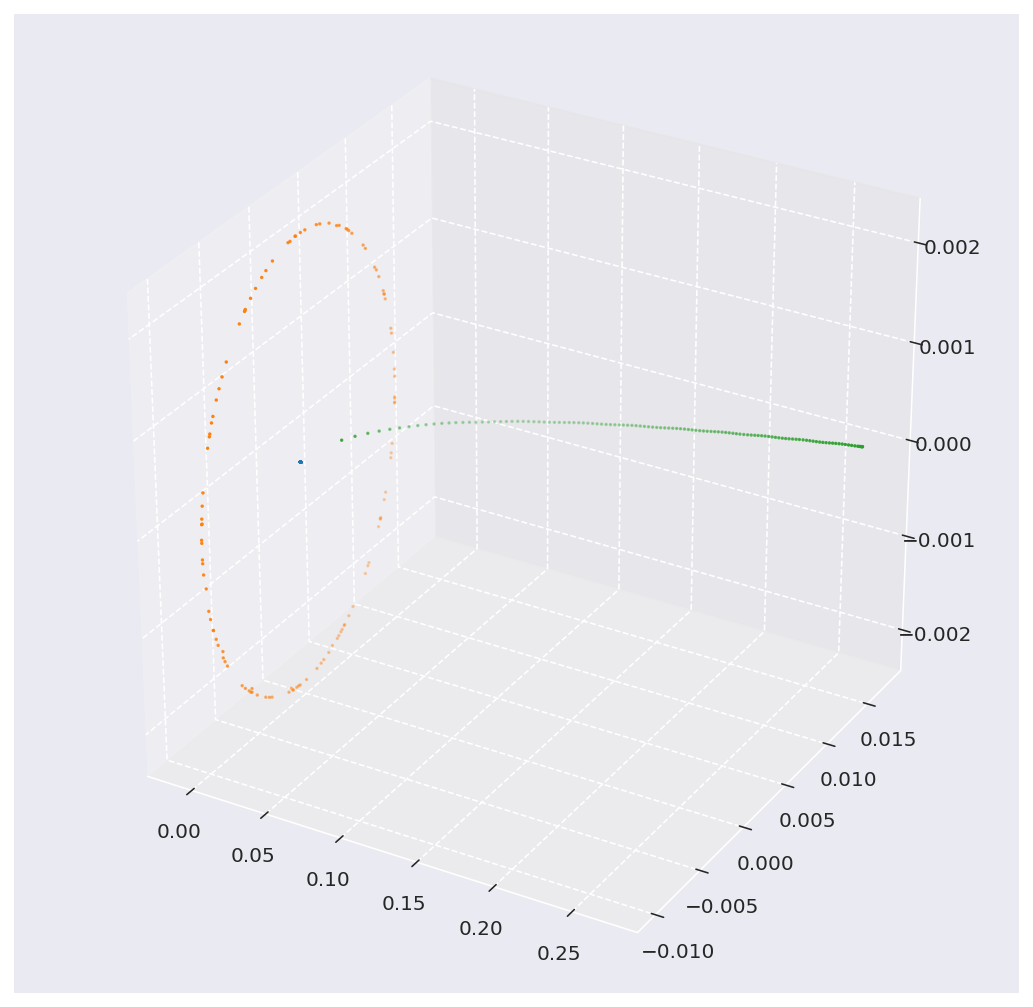

In [112]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p1[:,0], p1[:,1],p1[:,2],s=0.5)
ax.scatter(p2[:,0], p2[:,1],p2[:,2],s=0.5)
ax.scatter(p3[:,0], p3[:,1],p3[:,2],s=0.5)

In [8]:
sec = YR/365.25636042/24/3600
km=AU/149597870.7
print(km/sec-KMS)

-9.5167047395317e-08


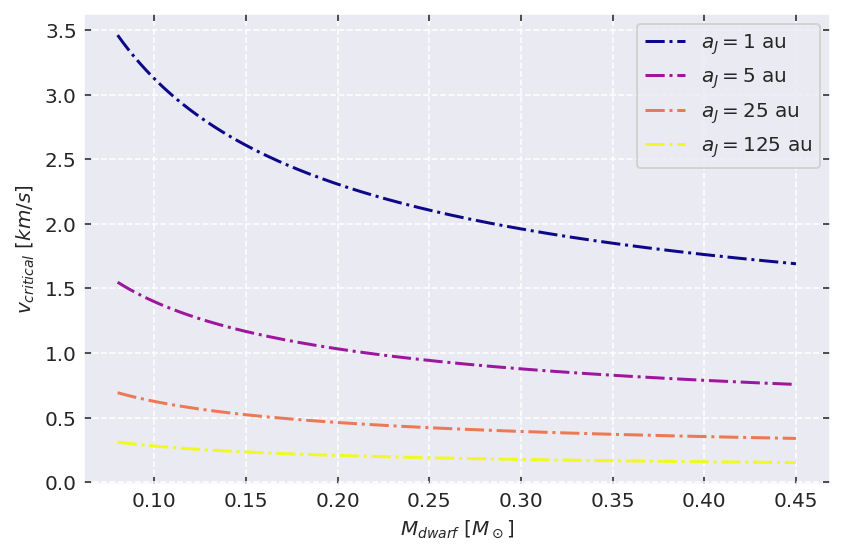

In [95]:
def critc_v(m1, m2, m3, a):
    m_in = m1 + m2
    mu_out = m_in * m3 / (m_in + m3)

    return np.sqrt(G / mu_out * m1 * m2 / a)

def critc_bv(m1, m2, m3, m4, a_in, a_out):
    m_in = m1 + m2
    m_out = m3+ m4
    mu_out = m_in * m_out / (m_in + m_out)

    return np.sqrt(G / mu_out * (m1 * m2 / a_in + m3*m4/a_out) )

def bmax(vc, v_inf, a_max):
    return (4*vc/v_inf + 3)*a_max

M_dwarf = np.linspace(0.08, 0.45, 1000)

m1 = 1
m2 = 1e-3

a_p = [1, 5, 25, 125]
a_label=['$a_J=1$ au', '$a_J=5$ au', '$a_J=25$ au', '$a_J=125$ au', ]

v = np.array([ critc_v(m1, m2, M_dwarf, a) for a in a_p ])/KMS




colors = cm.plasma(np.linspace(0,1,len(v)))
for vv,label,c in zip(v,a_label,colors):
    plt.plot(M_dwarf, vv, '-.',label=label,color=c)
plt.xlabel('$M_{dwarf}$ $[M_\odot]$')
plt.ylabel('$v_{critical}$ $[km/s]$')

plt.tight_layout()
plt.legend()
savefig(plt,'critical_v')



In [4]:
def load_orbit(data,orbit_name):
    name = ['m1', 'm2', 'e', 'p', 'i', 'Omega', 'omega', 'nv']
    orbit={}
    for key, i in zip(name, range(len(name))):
        orbit.update({orbit_name+key : data[:,i]})
    return orbit

def load_incid_args(data):
    return {'v_inf': data[:,0], 'b':data[:,1], 'w':data[:,2], 'ii':data[:,3],'iphi':data[:,4]}

def load_post_scattered(data, obj_name):
    dic = {'time':data[:,0]}
    for name, idx in zip(obj_name, range(len(obj_name))):
        offset = 10*idx
        dic.update({'m_{' + name + '}': data[:,offset + 3],
                    'r_{' + name + '}': data[:,offset + 4],
                    'px_{' + name + '}': data[:,offset + 5],
                    'py_{' + name + '}': data[:,offset + 7],
                    'pz_{' + name + '}': data[:,offset + 7],
                    'vx_{' + name + '}': data[:,offset + 8],
                    'vy_{' + name + '}': data[:,offset + 9],
                    'vz_{' + name + '}': data[:,offset + 10]
                   })
    return dic
        
def load_closest(data, obj_name):
    dic ={}
    for name, idx in zip(obj_name, range(len(obj_name))):
        offset = 6*idx
        dic.update({'closest:px_{' + name + '}': data[:,offset + 0],
                    'closest:py_{' + name + '}': data[:,offset + 1],
                    'closest:pz_{' + name + '}': data[:,offset + 2],
                    'closest:vx_{' + name + '}': data[:,offset + 3],
                    'closest:vy_{' + name + '}': data[:,offset + 4],
                    'closest:vz_{' + name + '}': data[:,offset + 5]})
    return dic
        
def load_data(fname, os, objname):
    data = np.loadtxt(fname)
    
    dic = {}
    dic.update(load_orbit(data[:,os['sj-orbit-s']:os['sj-orbit-e']],'sj-orbit-') )
    dic.update(load_incid_args(data[:,os['incident-s']:os['incident-e']]))
    
    dic.update(load_post_scattered(data[:,os['post-s']:os['post-e']], objname))
    
    if 'closest-s' and 'closest-e' in os:
        dic.update(load_closest(data[:,os['closest-s']:os['closest-e']], objname))
    
    if 'sn-orbit-s' and 'sn-orbit-e' in os:
        dic.update(load_orbit(data[:,os['sn-orbit-s']:os['sn-orbit-e']],'sn-orbit-'))
        
    if 'ss-orbit-s' and 'ss-orbit-e' in os:
        dic.update(load_orbit(data[:,os['ss-orbit-s']:os['ss-orbit-e']],'ss-orbit-'))
        
    return dic

def get_a_e(m, drx, dry, drz, dvx, dvy, dvz):
    r  = np.sqrt(drx**2 + dry**2 + drz**2)
    v2 = dvx**2 + dvy**2 + dvz**2
    v  = np.sqrt(v2)
    
    vrdot = drx*dvx + dry*dvy + drz*dvz
    
    vdfsq = (v2 - m / r)
    ex = (vdfsq * drx - vrdot * dvx)
    ey = (vdfsq * dry - vrdot * dvy) 
    ez = (vdfsq * drz - vrdot * dvz) 
    e  = np.sqrt(ex * ex + ey * ey + ez * ez) / m
    a  = -m / (v2 - 2 * m/r)
    return a, e


def calc_pair_a_e(data, pairs):
    for name_i, name_j in pairs:
        mi = data['m_{' + name_i + '}']
        mj = data['m_{' + name_j + '}']
        
        dpx = data['px_{' + name_i + '}'] - data['px_{' + name_j + '}']
        dpy = data['py_{' + name_i + '}'] - data['py_{' + name_j + '}']
        dpz = data['pz_{' + name_i + '}'] - data['pz_{' + name_j + '}']
        
        dvx = data['vx_{' + name_i + '}'] - data['vx_{' + name_j + '}']
        dvy = data['vy_{' + name_i + '}'] - data['vy_{' + name_j + '}']
        dvz = data['vz_{' + name_i + '}'] - data['vz_{' + name_j + '}']
        

        a, e = get_a_e(mi + mj, dpx, dpy, dpz, dvx, dvy, dvz)
        
        data['a_{' + name_i + ',' + name_j + '}'] = a
        
        data['e_{' + name_i + ',' + name_j + '}'] = e
        
def calc_tidal_t_scale(data, star_name, planet_name='j'):
    mp = data['m_{'+planet_name+ '}']
    rp = data['r_{'+planet_name+ '}']
    
    for name in star_name:
        rs = data['r_{' + name + '}']
        ms = data['m_{' + name + '}']
        #s = 9.0/4/2e7*mp/ms*rs**5
        p = 9.0/4/2.5e4*ms/mp*rp**5
        a = data['a_{' + name + ',' + planet_name + '}']
        e = data['e_{' + name + ',' + planet_name + '}']
        n = np.sqrt( G*(ms+mp)/a**3)
        tau_ap = 3/n*a**5/14/e**2/p
        data['T_{' + name + ',' + planet_name + '}'] = tau_ap

def check_collision(data, pairs):
    dic ={}
    for name_i, name_j in pairs:
        ri = data['r_{' + name_i + '}']
        rj = data['r_{' + name_j + '}']
        
        dpx = data['px_{' + name_i + '}'] - data['px_{' + name_j + '}']
        dpy = data['py_{' + name_i + '}'] - data['py_{' + name_j + '}']
        dpz = data['pz_{' + name_i + '}'] - data['pz_{' + name_j + '}']
        
        
        coll = (dpx**2 + dpy**2 + dpz**2) <= (ri + rj)**2
        
        
        data.loc[coll, 'star outcome'] = 'coll_{' + name_i + ',' + name_j + '}'
        data.loc[coll, 'planet outcome']= 'coll_{' + name_i + ',' + name_j + '}'
        #dic.update({'coll_{' + name_i + ',' + name_j + '}': coll})
    #return dic

def classify_star_outcome(data, star_pairs):
    init_bound = np.ones(data['time'].shape, dtype=bool)
    init_unbound =np.ones(data['time'].shape, dtype=bool)
    disrupted = np.zeros(data['time'].shape, dtype=bool)
    
    for name_i, name_j in star_pairs:
        if (name_i == 's1') and (name_j == 's2'):
            a = data['a_{' + name_i + ',' + name_j + '}']
            e = data['e_{' + name_i + ',' + name_j + '}']
        
            bound = (a > 0) & (0 <=e) & (e < 1)
            unbound = (e >= 1) & (a <= 0) 
            init_bound = init_bound & bound
            init_unbound=init_unbound&unbound
            disrupted = np.ones(data['time'].shape, dtype=bool)
    
    
    flyby = np.ones(data['time'].shape, dtype=bool)
    
    bi_formation ={}
    for name_i, name_j in star_pairs:
        if (name_i != 's1') or (name_j != 's2'):
            a = data['a_{' + name_i + ',' + name_j + '}']
            e = data['e_{' + name_i + ',' + name_j + '}']
        
            bound = (a > 0) & (0 <=e) & (e < 1)
            unbound = (e >= 1) & (a <= 0) 
            
            bi_formation.update({'reunion_{' + name_i + ',' + name_j + '}': bound & init_unbound})
        
            flyby = flyby & unbound & init_bound
            
            disrupted = disrupted & unbound & init_unbound
        
    reunion = np.zeros(data['time'].shape, dtype=bool)
    for key, r in bi_formation.items():
        reunion = reunion | r
        
    data.loc[reunion, 'star outcome'] = 'reunion'
    data.loc[flyby,'star outcome'] = 'flyby'
    data.loc[disrupted, 'star outcome'] = 'disrupted'
    
    #dic = {'reunion':reunion, 'flyby' : flyby, 'disrupted': disrupted}
    
    #dic.update(bi_formation)
            
    #return dic

def classify_planet_outcome(data, star_names, planet_name='j', a_final=0.1*AU):
    binary = []
    for star_name in star_names:
        a = data['a_{' + star_name + ',' + planet_name + '}']
        e = data['e_{' + star_name + ',' + planet_name + '}']
        tau_ap = data['T_{' + star_name + ',' + planet_name + '}']
        
        bound = (a > 0) & (0 <=e) & (e < 1)
        unbound = (e >= 1) & (a <= 0) 
        hot_jupiter_candi = (a*(1-e*e) < a_final) & (tau_ap < Hubble_t) 
        binary.append((star_name, bound, unbound, hot_jupiter_candi))
        
    dic={}
    for star_name1, bound1, unbound1, hj1 in binary:
        bound = bound1
        hot_jupiter = hj1
        for star_name2, bound2, unbound2, hj2 in binary:
            if(star_name1 != star_name2):
                bound = bound & unbound2
                hot_jupiter = hot_jupiter & unbound2
                
        data.loc[bound, 'planet outcome'] = 'stay_{' + star_name1 + ',' + planet_name + '}'
        data.loc[hot_jupiter, 'planet outcome']= 'HJ_{' + star_name1 + ',' + planet_name + '}' 
    
        #dic.update({'stay_{' + star_name1 + ',' + planet_name + '}' : bound, 'HJ_{' + star_name1 + ',' + planet_name + '}' : hot_jupiter})
        
    ejection = np.ones(data['time'].shape, dtype=bool)
    for star_name, bound, unbound, hj in binary:
        ejection = ejection & unbound
        
        
    data.loc[ejection, 'planet outcome'] = 'ejection_{'+planet_name+'}'
    
    #dic.update({'ejection_{'+planet_name+'}':ejection})

    #return dic
def analy_outcomes(data, objname, pairs):
    star_name = [ name for name in objname if name.startswith('s')]
    planet_name = [ name for name in objname if not name.startswith('s')]
    star_pairs = [(s1, s2) for s1, s2 in pairs if s1.startswith('s') and s2.startswith('s')]
    
        #print(star_name, planet_name, star_pairs)
    
    data['star outcome']= np.zeros(data['time'].shape,dtype = object)
    data['planet outcome']= np.zeros(data['time'].shape,dtype = object)
    calc_pair_a_e(data, pairs)
    
    classify_star_outcome(data, star_pairs)
   
    for p_name in planet_name:
        calc_tidal_t_scale(data, star_name, p_name)
        classify_planet_outcome(data, star_name, p_name)
        
        check_collision(data, pairs)
        
    return data
    
def post_process(fname, os, objname, pairs):
    data = pd.DataFrame(load_data(fname, os, objname))
    
    return analy_outcomes(data, objname, pairs)
    #return parallelize_dataframe(12, analy_outcomes, data, objname, pairs)

In [5]:
prefix = '/home/yihan/Projects/giant-planet/code/single/'

mono_single_idx = {'sj-orbit-s' : 1, 'sj-orbit-e':9, 'incident-s':9, 'incident-e':14, 'post-s':14, 'post-e':45}

names = ['s','j', 's1']

pairs = [('s','j'), ('s','s1'), ('s1','j')]


In [6]:
open_single = pd.DataFrame(post_process(prefix+'open-single.txt', mono_single_idx, names, pairs))

/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt


In [7]:
field_single = pd.DataFrame(post_process(prefix+'field-single.txt', mono_single_idx, names, pairs))

/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt


In [8]:
globular_single = pd.DataFrame(post_process(prefix+'globular-single.txt', mono_single_idx, names, pairs))

/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt


In [17]:
prefix = '/home/yihan/Projects/giant-planet/code/binary/'

binary_idx = {'sj-orbit-s' : 1, 'sj-orbit-e':9, 'incident-s':9, 'incident-e':14, 'post-s':14, 'post-e':56}

names = ['s','j', 's1', 's2']

pairs = [('s','j'), ('s','s1'), ('s1','j'), ('s','s2'), ('s2','j'), ('s1','s2')]

In [18]:
open_binary = pd.DataFrame(post_process(prefix+'open-binary.txt', binary_idx, names, pairs))

/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt


In [19]:
field_binary = pd.DataFrame(post_process(prefix+'field-binary.txt', binary_idx, names, pairs))

/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt


In [ ]:
globular_binary = pd.DataFrame(post_process(prefix+'globular-binary.txt', binary_idx, names, pairs))

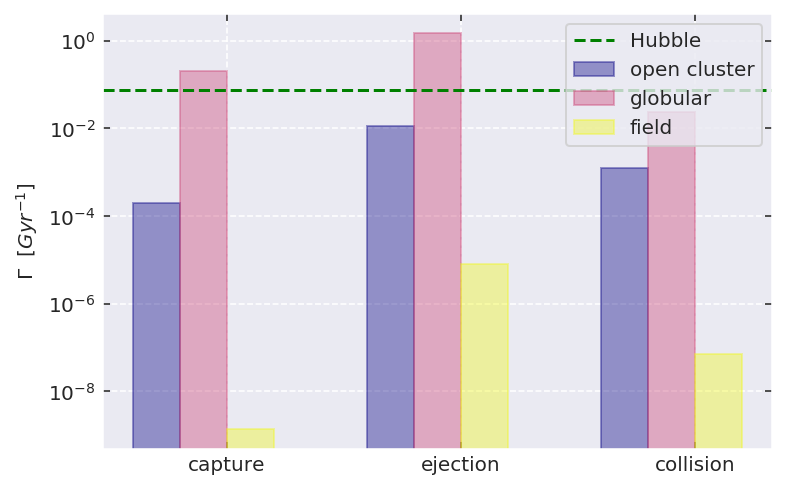

In [103]:
def calc_ratio(out, classify, outname):
    tot_num = len(out)

    dic = {}
    for name_list, key in zip(classify,outname):
        num_out = 0
        for name in name_list:
            num_out += (out == name).sum()
        dic[key] = num_out / tot_num
        
    return dic

def draw_bar(data, names, classify, out_name, key='planet outcome'):
    
    ratio = [calc_ratio(x[key], classify, out_name) for x in data]
    b_max = [x['b'].max() for x in data]
    v_inf = [x['v_inf'].max() for x in data]
    n_den = [100/PC**3, 100000/PC**3, 1/PC**3]
    stack_num = len(ratio)
    width = 0.6 / stack_num
    colors = cm.plasma(np.linspace(0,1,len(names)))
    
    for i, name, r, b, v , n , c in zip(range(len(names)), names, ratio, b_max, v_inf, n_den,colors):
        f = [value for key, value in r.items()]
        #* 
        y=[ff* np.pi* b**2 * n * v * 1E9*YR  for ff in f]
        
        plt.bar(np.array(range(len(r)))+ i*width, y, width, label=name,color=c,alpha=0.4,lw=1,edgecolor=c)
    plt.axhline(1/Hubble_t*1E9*YR,ls='--',c='g',label='Hubble')
    labels = [l for l in list(ratio[1].keys())]
    plt.xticks(np.array(range(len(r))) + len(names)/2*width, labels )
    plt.legend()
    #plt.ylabel('$\sigma [PC^2]$')
    #plt.ylabel('outcome fraction')
    plt.ylabel('$\Gamma$  $[Gyr^{-1}]$')
    plt.yscale('log')
    savefig(plt,'single-rate')
    
    
#['HJ_{s,j}','stay_{s,j}'], ['HJ_{s,j}','stay_{s,j}']
single_out = [  ['stay_{s1,j}', 'HJ_{s1,j}'],['ejection_{j}'], ['coll_{s,s1}', 'coll_{s,j}', 'coll_{s1,j}']]

binary_out = [  ['stay_{s2,j}', 'stay_{s1,j}','HJ_{s1,j}','HJ_{s2,j}'], ['ejection_{j}'], ['coll_{s2,j}', 'coll_{s1,s2}',  'coll_{s1,j}' , 'coll_{s,s1}', 'coll_{s,s2}', 'coll_{s,j}']]

out_name = [ 'capture', 'ejection', 'collision']

#draw_bar([open_binary, field_binary], ['open cluster','globular'], binary_out, out_name)

draw_bar([open_single, field_single, globular_single], ['open cluster','globular','field'], single_out, out_name)

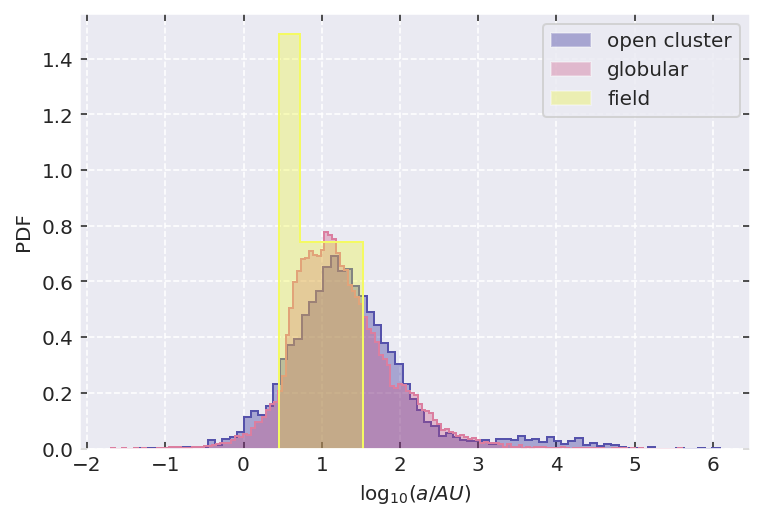

In [92]:
def get_sma(out, capture):
    ccc = out['planet outcome'] == ''
    for cap in capture:
        ccc = ccc | (out['planet outcome'] == cap)
        
    return out['a_{s1,j}'][ccc]

def draw_a_dist(data, names, capture):
    sma = [ get_sma(x, capture) for x in data]
    colors = cm.plasma(np.linspace(0,1,len(sma)))
    for a, name, c in zip(sma,names,colors):
        plt.hist(np.log10(a),bins='auto',histtype='step',density=True,lw=1,color=c)
        plt.hist(np.log10(a),bins='auto',histtype='stepfilled',label=name,density=True,alpha=0.3,color=c)
    plt.legend()
    plt.xlabel('$\log_{10}(a/AU)$')
    plt.ylabel('PDF')
    savefig(plt,'cap_sma')
    
single_cap = ['stay_{s1,j}', 'HJ_{s1,j}']

draw_a_dist([open_single, field_single, globular_single], ['open cluster','globular','field'], single_cap)    

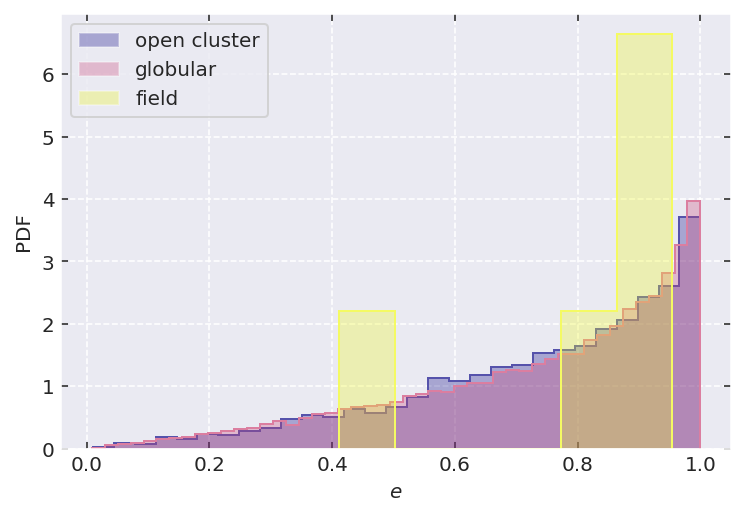

In [93]:
def get_ecc(out, capture):
    ccc = out['planet outcome'] == ''
    for cap in capture:
        ccc = ccc | (out['planet outcome'] == cap)
        
    return out['e_{s1,j}'][ccc]

def draw_e_dist(data, names, capture):
    ecc = [ get_ecc(x, capture) for x in data]
    colors = cm.plasma(np.linspace(0,1,len(ecc)))
    for e, name, c in zip(ecc,names,colors):
        plt.hist(e,bins='auto',histtype='step',density=True,lw=1,color=c)
        plt.hist(e,bins='auto',histtype='stepfilled',label=name,density=True,alpha=0.3,color=c)
    plt.legend()
    plt.xlabel('$e$')
    plt.ylabel('PDF')
    savefig(plt,'cap_ecc')
    
single_cap = ['stay_{s1,j}', 'HJ_{s1,j}']

draw_e_dist([open_single, field_single, globular_single], ['open cluster','globular','field'], single_cap)    

In [52]:
((PC**2 *KMS / PC**3) *YR*1E10)

10227.328733875784

In [40]:
def critical_v(m1, m2, m3, a):
    m_in = m1 + m2
    mu_out = m_in * m3/(m_in + m3)
    
    return np.sqrt(G/mu_out*m1*m2/a)

def calc_cross_section(filename, idx, column_name, pairs):
    df = pd.DataFrame(post_process(filename, idx, names, pairs))
    b_max = df['b'].max()
    planet_out = df['planet outcome']
    
    star_out = df['star outcome']
    
    ncap =((planet_out == 'stay_{s1,j}')&(star_out == 'flyby')).sum()
    
    ntot = len(planet_out)
    
    sigma = np.pi * b_max**2 * ncap/ntot
    
    m_dwarf = df['m_{s1}'][0]
    
    return m_dwarf, sigma, b_max, ncap, ntot, df['v_inf'].mean()/KMS

def calc_HJ_cross_section(filename, idx, column_name, pairs):
    df = pd.DataFrame(post_process(filename, idx, names, pairs))
    b_max = df['b'].max()
    planet_out = df['planet outcome']
    
    star_out = df['star outcome']
    
    ncap =(planet_out == 'HJ_{s,j}').sum()
    
    ntot = len(planet_out)
    
    m_dwarf = df['m_{s1}'][0]
    
    if 'm_{s2}' in df.columns:
        m_dwarf += df['m_{s2}'][0]
        
    sigma = np.pi * b_max**2 * ncap/ntot
    
    return m_dwarf, sigma, b_max, ncap, ntot, df['v_inf'].mean()/KMS

def calc_cap_HJ_cross_section(filename, idx, column_name, pairs):
    df = pd.DataFrame(post_process(filename, idx, names, pairs))
    b_max = df['b'].max()
    planet_out = df['planet outcome']
    
    star_out = df['star outcome']
    
    ncap =(planet_out == 'HJ_{s1,j}').sum()
    
    ntot = len(planet_out)
    
    m_dwarf = df['m_{s1}'][0]
    
    if 'm_{s2}' in df.columns:
        m_dwarf += df['m_{s2}'][0]
        ncap += (planet_out == 'HJ_{s2,j}').sum()
        
    sigma = np.pi * b_max**2 * ncap/ntot
    
    return m_dwarf, sigma, b_max, ncap, ntot, df['v_inf'].mean()/KMS

def calc_ejection_cross_section(filename, idx, column_name, pairs):
    df = pd.DataFrame(post_process(filename, idx, names, pairs))
    b_max = df['b'].max()
    planet_out = df['planet outcome']
    
    star_out = df['star outcome']
    
    ncap =(planet_out == 'ejection_{j}').sum()
    
    ntot = len(planet_out)
    
    sigma = np.pi * b_max**2 * ncap/ntot
    
    m_dwarf = df['m_{s1}'][0]
    
    if 'm_{s2}' in df.columns:
        m_dwarf += df['m_{s2}'][0]
    
    return m_dwarf, sigma, b_max, ncap, ntot, df['v_inf'].mean()/KMS

def calc_binary_cross_section(filename, idx, column_name, pairs):
    df = pd.DataFrame(post_process(filename, idx, names, pairs))
    b_max = df['b'].max()
    planet_out = df['planet outcome']
    
    star_out = df['star outcome']
    
    ncap =(((planet_out == 'stay_{s1,j}') | (planet_out == 'stay_{s2,j}') )&(star_out == 'flyby')).sum()
    
    ntot = len(planet_out)
    
    sigma = np.pi * b_max**2 * ncap/ntot
    
    m_dwarf = df['m_{s1}'][0] + df['m_{s2}'][0]
    
    return m_dwarf, sigma, b_max, ncap, ntot, df['v_inf'].mean()/KMS

def get_dataframe(callback, prefix, idx, names, pairs, m_num):
    fnames = [prefix + 'Maxwellian_' + str(i) + '.txt' for i in range(m_num)]
    
    res = parallelize(12,callback, fnames, idx, names, pairs)
    
    M, SIGMA, B, Ncap, Ntot, V = zip(*res)
    
    aj=1*AU

    sigma_unit = np.pi*aj*aj

    cross = pd.DataFrame({'$m_{dwarf}[M_\odot]$': M, '$V_{inf} [km/s]$':V, '$b_{max} [au]$':B, '$N_{cap}$':Ncap, '$N_{tot}$':Ntot, '$\sigma[\pi a_{J}^2]$':np.array(SIGMA)/sigma_unit})

    cross['$\Delta\sigma [\pi a_{J}^2]$'] = cross['$b_{max} [au]$']**2*np.sqrt(cross['$N_{cap}$'])/cross['$N_{tot}$']*np.pi/sigma_unit

    cross['$v_{crit} [km/s]$'] = critical_v(1, 0.000954, cross['$m_{dwarf}[M_\odot]$'], 1)/KMS
    
    return cross

<>:113: DeprecationWarning: invalid escape sequence \o
<>:113: DeprecationWarning: invalid escape sequence \s
<>:115: DeprecationWarning: invalid escape sequence \D


In [41]:
prefix = '../code/single/'

mono_single_idx = {'sj-orbit-s' : 1, 'sj-orbit-e':9, 'incident-s':9, 'incident-e':14, 'post-s':14, 'post-e':45}

names = ['s','j', 's1']

pairs = [('s','j'), ('s','s1'), ('s1','j')]

cs = get_dataframe(calc_HJ_cross_section, prefix, mono_single_idx, names, pairs, 40)

#cross.to_csv(prefix+"data.csv")

/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value enco

In [42]:
prefix = '../code/binary-1/'

binary_idx = {'sj-orbit-s' : 1, 'sj-orbit-e':9, 'incident-s':9, 'incident-e':14, 'post-s':14, 'post-e':56}

names = ['s','j', 's1', 's2']

pairs = [('s','j'), ('s','s1'), ('s1','j'), ('s','s2'), ('s2','j'), ('s1','s2')]

cs_b_1 = get_dataframe(calc_HJ_cross_section, prefix, binary_idx, names, pairs, 40)

#cross_binary_1.to_csv(prefix+"data.csv")

/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value enco

In [43]:
prefix = '../code/binary-10/'

names = ['s','j', 's1', 's2']

pairs = [('s','j'), ('s','s1'), ('s1','j'), ('s','s2'),('s2','j'),('s1','s2')]

cs_b_10 = get_dataframe(calc_HJ_cross_section, prefix, binary_idx, names, pairs, 40)

/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value enco

In [44]:
prefix = '../code/binary-50/'

names = ['s','j', 's1', 's2']

pairs = [('s','j'), ('s','s1'), ('s1','j'), ('s','s2'),('s2','j'),('s1','s2')]

cs_b_50 = get_dataframe(calc_HJ_cross_section, prefix, binary_idx, names, pairs, 40)

/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value enco

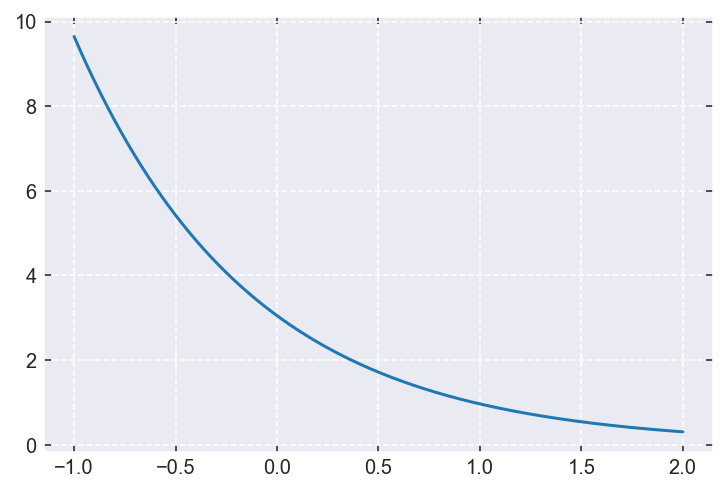

In [19]:
den=1000
a_x = 10**np.linspace(-1, 2, den)
m_x = np.linspace(0.08,0.45, 10)
m_x=0.1
v_y = critical_v(1, 0.000954, m_x, a_x)/KMS

plt.plot(np.log10(a_x), v_y)

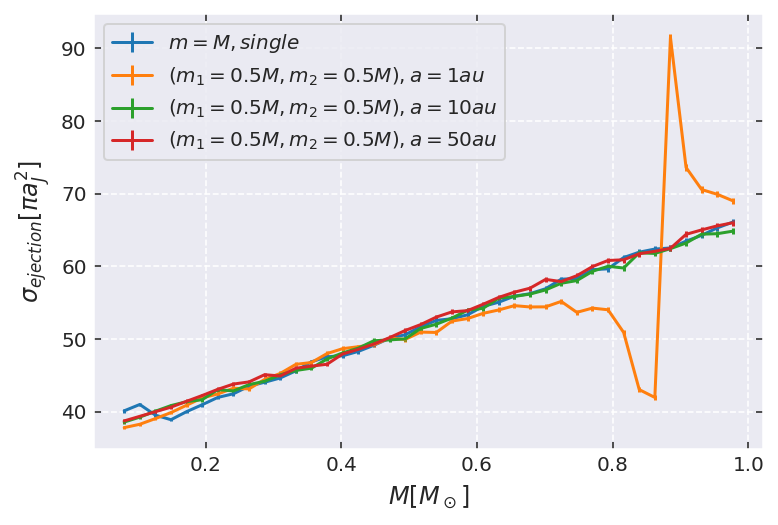

In [45]:
#sns.relplot( x='$m_{dwarf}[M_\odot]$',y='$\sigma[\pi a_{J}^2]$',data=cross,kind='line')
plt.errorbar(x=cs['$m_{dwarf}[M_\odot]$'], y=cs['$\sigma[\pi a_{J}^2]$'],yerr=cs['$\Delta\sigma [\pi a_{J}^2]$'],label='$m = M, single$')

plt.errorbar(x=cs_b_1['$m_{dwarf}[M_\odot]$'], y=cs_b_1['$\sigma[\pi a_{J}^2]$'],yerr=cs_b_1['$\Delta\sigma [\pi a_{J}^2]$'],label='$(m_1=0.5M, m_2=0.5M), a = 1au$')

plt.errorbar(x=cs_b_10['$m_{dwarf}[M_\odot]$'], y=cs_b_10['$\sigma[\pi a_{J}^2]$'],yerr=cs_b_10['$\Delta\sigma [\pi a_{J}^2]$'],label='$(m_1=0.5M, m_2=0.5M), a = 10au$')

plt.errorbar(x=cs_b_50['$m_{dwarf}[M_\odot]$'], y=cs_b_50['$\sigma[\pi a_{J}^2]$'],yerr=cs_b_50['$\Delta\sigma [\pi a_{J}^2]$'],label='$(m_1=0.5M, m_2=0.5M), a = 50au$')

plt.legend()

plt.xlabel('$M [M_\odot]$',fontsize=12)

plt.ylabel('$\sigma_{ejection}[\pi a_{J}^2]$',fontsize=12)

#plt.yscale('log')
savefig(plt,'maxwellian-v-stayed-HJ')

In [46]:
6.7/7.1

0.943661971830986

In [47]:
3600/0.94

3829.7872340425533